Козунов Артём \
степик ID: 37883835 \
телеграм: @landaunn

# Autoencoders

В этом ноутбуке мы будем тренировать автоэнкодеры кодировать лица людей. Для этого возьмем следующий датасет: "Labeled Faces in the Wild" (LFW) (http://vis-www.cs.umass.edu/lfw/). Код для скачивания и загрузки датасета написан за вас в файле get_dataset.py


# Vanilla Autoencoder (2 балла)

## Prepare the data


In [1]:
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import os
from skimage.transform import resize
import skimage.io
import pandas as pd

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=48,dimy=48
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos,all_attrs

In [5]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
#from get_dataset.py import fetch_dataset
data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done



Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [6]:
from sklearn.model_selection import train_test_split

tr, val = train_test_split(data, test_size=0.25,  random_state=42)

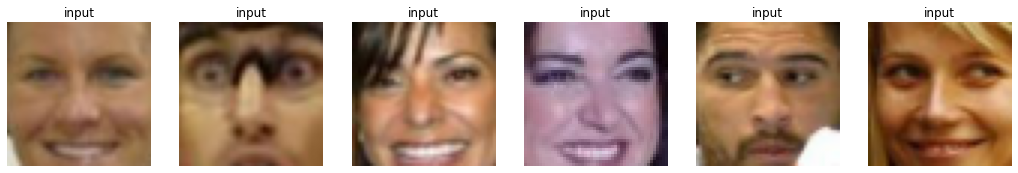

In [7]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(val[i])
    plt.title('input')

plt.show();

In [8]:
tr = np.rollaxis(tr, 3, 1)
val = np.rollaxis(val, 3, 1)

In [9]:
tr = torch.FloatTensor(tr)
val = torch.FloatTensor(val)

In [10]:

batch_size = 128

data_tr = DataLoader(tr, 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(val,
                      batch_size=batch_size, shuffle=True)

## Autoencoder
В этом разделе мы напишем и обучем обычный автоэнкодер.

Надеюсь, что к этому моменту вы уже почитали про автоэнкодеры и знаете, зачем они нужны и какова их архитектура. Если нет, то начните с этих ссылок: 

https://habr.com/ru/post/331382/ \\
https://towardsdatascience.com\intuitively-understanding-variational-autoencoders-1bfe67eb5daf



<img src="https://i.imgur.com/nVJAtMT.png" alt="Autoencoder">

^ вот так выглядит автоэнкодер

In [11]:
dim_code = 12*12*3  #<your code here> # выберите размер латентного вектора, т.е. code, самой "узкой" части автоэнкодера

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [12]:
from copy import deepcopy
from time import time

class Autoencoder(nn.Module):
    def __init__(self):
        '''<определите архитектуры encoder и decoder>'''
        super().__init__()
        #encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )

        #decoder
        self.deconv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2)

        self.deconv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2)

        self.deconv3 = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )


        
        
    def forward(self, x):
        
        '''<реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code) 
        и полученная реконструкция изображения (reconstruction)>'''

        x = self.pool1(self.conv1(x))
        #print(x.shape)
        latent_code = self.conv3(self.pool2(self.conv2(x)))
        #print(latent_code.shape)

        x = self.upsample1(self.deconv1(latent_code))
        #print(x.shape)
        reconstruction = self.deconv3(self.upsample2(self.deconv2(x)))
        #print(reconstruction.shape)
        
        
        return reconstruction, latent_code

    def recovery(self, latent_code):
        x = self.upsample1(self.deconv1(latent_code))
        #print(x.shape)
        reconstruction = self.deconv3(self.upsample2(self.deconv2(x)))
        #print(reconstruction.shape)
        return reconstruction

In [13]:
criterion = nn.MSELoss().to(device)

autoencoder = Autoencoder().to(device)

optimizer = optim.AdamW(autoencoder.parameters(), lr=3e-4)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [14]:
def plot(history):
    train_loss, val_loss = zip(*history)
    
    plt.figure(figsize=(15, 9))
    plt.plot(train_loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [15]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))
    
    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
       
        model.train()  # train mode
        for X_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            X_pred,_ = model(X_batch)
            loss = loss_fn(X_batch, X_pred)# forward-pass
            loss.backward()# backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss /len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        X_hat,_ = model(X_val.to(device)) # detach and put into cpu
       
        val_loss = 0

        for X_batch in data_val:
          # data to device
          X_batch = X_batch.to(device)

          with torch.set_grad_enabled(False):
            X_pred,_ = model(X_batch)
            loss = loss_fn(X_batch, X_pred)

          val_loss += loss  / len(data_val)
        
        history.append((avg_loss, val_loss))

          # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.imshow(np.moveaxis( X_val.to('cpu').numpy(), 1, 3)[i])
            plt.title('input')
            plt.axis('off')
            #print(np.moveaxis(X_val.numpy(), 1, 3)[i])
            

            plt.subplot(2, 6, i+7)
            plt.imshow(np.moveaxis(X_hat.detach().to('cpu').numpy(), 1, 3)[i])
            plt.title('output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        plot(history)


    return history

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


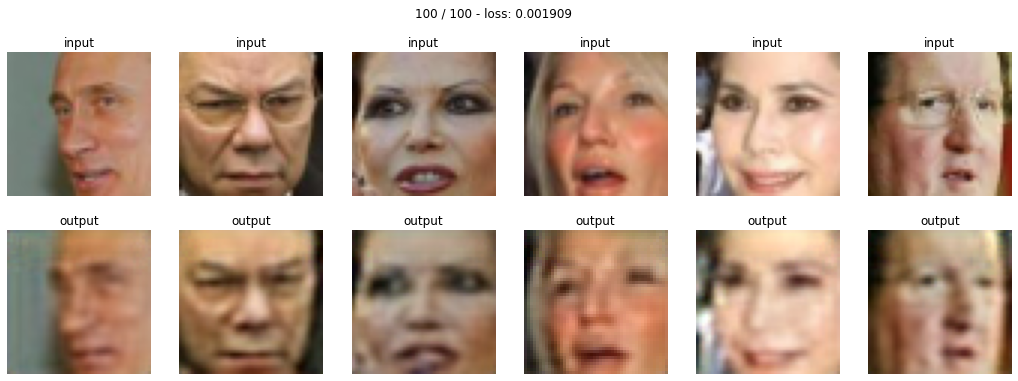

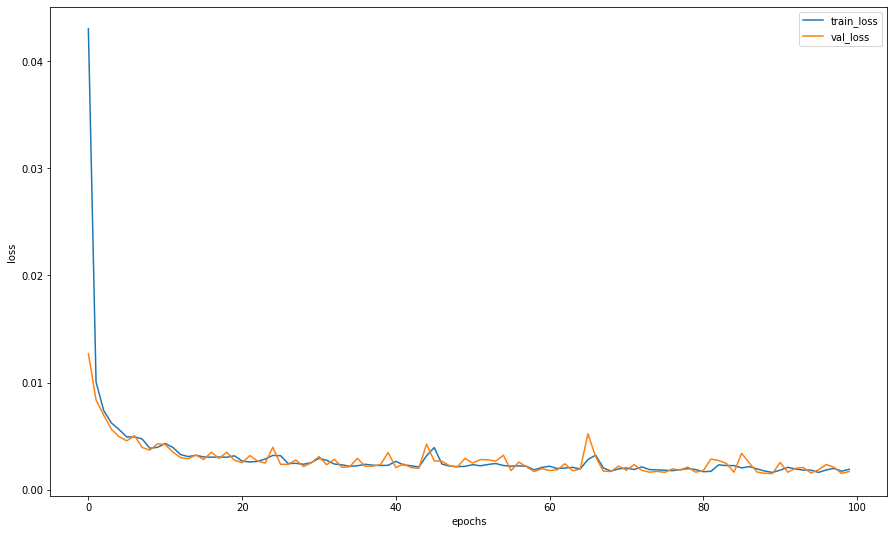

In [ ]:
history = train(autoencoder, optimizer, criterion, 100, data_tr, data_val)

In [17]:
import pickle
def save_history(history, name):
  path_name = 'drive/My Drive/project/' + name + '_history.pickle'
  with open(path_name, 'wb') as f:
    pickle.dump(history, f)

In [ ]:
save_history(history, 'AE(100epochs)')

In [ ]:
import copy

model_weights = copy.deepcopy(autoencoder.state_dict())
torch.save(model_weights, "drive/My Drive/project/AE(100epochs).pth")

Not bad, right? 

## Sampling

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

#### If that doesn't work
Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как np.random.randn(25, <latent_space_dim>). А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как лаьентные векторы реальных фоток. Так что ридется рандом подогнать.

In [21]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_code).reshape((25, 3, 12, 12))
z = torch.FloatTensor(z).to(device)
output = autoencoder.recovery(z)
#<выведите тут полученные картинки>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

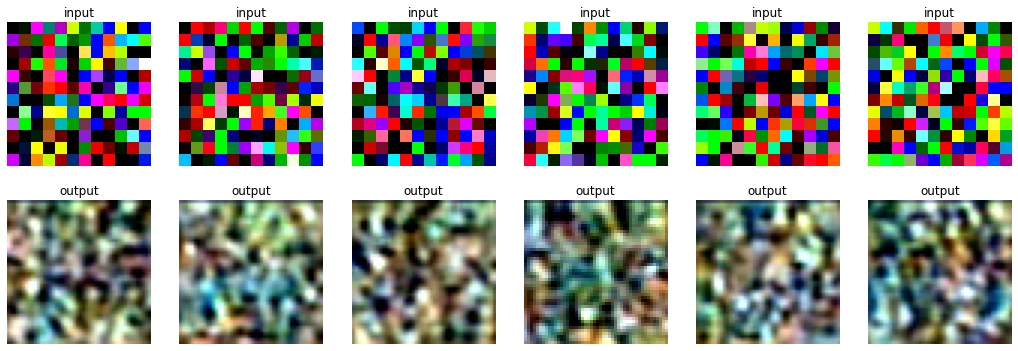

In [22]:
 plt.figure(figsize=(18, 6))
 for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.moveaxis( z.to('cpu').numpy(), 1, 3)[i])
    plt.title('input')
    plt.axis('off')
            

    plt.subplot(2, 6, i+7)
    plt.imshow(np.moveaxis(output.detach().to('cpu').numpy(), 1, 3)[i])
    plt.title('output')
    plt.axis('off')
    
plt.show()

## Congrats!

Time to make fun!

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1) Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15 сойдет) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2) Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3) Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

3) А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного чувака и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [23]:
attrs[attrs.Smiling >= 1.5][:15]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
26,1.89823,1.08339,-1.22851,-1.41631,-2.75757,-1.10117,-0.470595,-0.218677,-0.806491,-1.41484,-1.00858,0.202754,0.0703547,0.400184,-0.385587,-1.5906,-0.178473,1.51203,-1.65498,0.124311,-0.920825,-0.811478,-0.195442,-0.749001,-0.614256,-0.723917,0.0311348,1.52504,0.619817,-0.737565,-0.23283,0.677438,-0.714539,-0.932887,1.58934,0.882231,2.50064,0.36015,1.68482,-0.917577,0.0447821,-1.65507,0.846196,-0.552155,-0.962588,-0.189775,-0.228528,0.150663,0.0904241,-0.875054,-1.20458,-0.36221,-0.347131,6.45665,0.509957,0.00911267,-0.705268,-0.778349,-0.664233,0.938811,-1.13663,0.900562,-0.104972,-0.851258,-0.0420624,0.769485,-1.10999,1.39239,0.856509,1.97301,-1.03737,0.694004,-0.928776
88,-0.975435,-0.746867,0.658828,-2.61394,-1.352,-2.05394,0.593879,-0.43186,-1.98153,0.0778765,-0.267576,-0.465173,-0.56894,2.55695,-2.27902,-1.4743,-1.13382,2.53044,-2.44052,-0.841163,-0.565579,-1.82611,0.50964,0.855098,-0.76238,-0.455611,-0.00428206,-0.0705928,-0.643323,-1.5185,-0.619003,1.33606,-1.45049,-1.57342,-0.960926,-0.278234,2.64851,-0.452578,-0.179682,1.21294,-0.134894,-3.0574,1.04784,-0.200112,-2.03777,1.55725,-1.17183,0.350068,-0.358463,-1.31385,1.12967,-0.796049,-0.976573,2.25934,0.432096,0.710291,-0.0364632,-1.22574,-1.85429,-0.428341,-0.249503,-0.921873,0.485886,0.584507,-1.66427,0.844532,1.03372,-1.13334,0.875383,1.87318,0.130292,-0.534467,0.670804
106,-0.254734,-0.682719,-0.284188,-2.33204,-2.75135,-0.894461,0.0310605,-0.592413,-1.10991,-0.159199,-0.74984,1.39775,-1.4681,1.64639,-1.64665,-1.09822,-1.23354,1.63769,-1.71419,-0.769719,-1.48302,-1.34912,-1.06532,1.18735,0.430526,-0.124238,-1.03357,0.27073,-0.935404,-1.13487,-0.191497,-1.30818,-0.24455,-0.339317,0.0438264,0.362965,1.42334,0.491116,0.892833,0.00119869,-0.558381,-1.26007,0.97227,-1.48466,-1.36093,0.708486,-0.107383,0.298531,-0.803684,-1.26733,0.0155631,-0.916229,-0.51178,3.7738,0.729316,0.444757,-0.236565,-0.560032,-1.27318,0.535847,-0.495591,-0.604232,-0.923125,-0.766079,-0.159962,0.998266,0.2888,-2.27548,0.692226,0.484514,-0.0437698,0.384044,0.929954
108,-1.15553,-0.438666,0.13535,-1.98185,-1.86384,-1.17053,0.443239,-0.421654,-1.55696,-1.56162,-0.0403224,0.820157,-1.86734,1.24738,-2.21414,-1.31381,-1.21032,2.55365,-2.50777,-1.05418,-0.213131,-1.42182,0.525602,0.546533,-1.32393,-1.09077,0.582295,0.226257,-1.85602,-2.00919,-0.830985,0.588892,-0.332633,-1.684,-1.03581,-0.501233,-0.0300026,1.61409,-0.430605,0.285607,0.324931,-1.81107,0.731527,-0.374174,-1.82551,1.14767,-1.01395,0.44054,-0.0793428,-1.15789,-0.0549029,-0.884523,-0.45999,3.75707,1.24191,0.413805,0.285492,-1.02585,-1.52823,-0.634966,1.48987,0.961881,-0.0489386,0.799025,-2.27926,0.411455,2.08796,-0.11792,1.05065,0.301667,0.589475,-0.339884,0.101929
135,-2.28965,-0.778843,-0.569674,-1.6772,-1.96358,-1.33493,0.61084,-0.60911,-1.56756,-0.194772,-1.54314,1.73802,-2.59258,1.45608,-1.38626,-1.36456,-1.13185,2.5625,-2.39824,-0.38171,0.428236,-0.786915,-0.481998,0.316448,-0.191001,-1.27205,0.093934,0.654748,-1.96996,-0.489281,-0.511585,-0.807131,-0.282865,-1.05434,-0.573107,1.02483,1.6248,1.25505,0.452568,0.416146,1.12007,-1.48789,1.09047,-0.807398,-1.57064,1.12802,-1.05802,0

In [24]:
smile_people = data[[26, 88, 106, 108, 135, 136, 137, 138, 146, 158, 159, 219, 220, 237, 253]]

In [25]:
attrs[attrs.Smiling <= -1.5][:15]

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,Blond Hair,Brown Hair,Bald,No Eyewear,Eyeglasses,Sunglasses,Mustache,Smiling,Frowning,Chubby,Blurry,Harsh Lighting,Flash,Soft Lighting,Outdoor,Curly Hair,Wavy Hair,Straight Hair,Receding Hairline,Bangs,Sideburns,Fully Visible Forehead,Partially Visible Forehead,Obstructed Forehead,Bushy Eyebrows,Arched Eyebrows,Narrow Eyes,Eyes Open,Big Nose,Pointy Nose,Big Lips,Mouth Closed,Mouth Slightly Open,Mouth Wide Open,Teeth Not Visible,No Beard,Goatee,Round Jaw,Double Chin,Wearing Hat,Oval Face,Square Face,Round Face,Color Photo,Posed Photo,Attractive Man,Attractive Woman,Indian,Gray Hair,Bags Under Eyes,Heavy Makeup,Rosy Cheeks,Shiny Skin,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
49,1.29374,-0.243852,-0.850693,-0.904234,-1.73517,-0.314889,-0.782324,-0.190865,-0.685499,0.516741,-1.82921,1.5368,-1.22117,1.24328,-0.886387,-1.81244,0.0192637,-2.30731,2.19098,-0.929739,1.47928,-0.200362,-1.43223,0.244065,-0.938571,0.140222,-0.293078,1.41214,0.505523,-1.30601,0.704294,1.34014,-0.599131,-1.26483,0.915439,0.373173,1.42724,-1.56692,0.118814,0.436591,0.579168,0.327944,-0.965384,-0.928338,1.52193,-0.604202,0.209946,0.292959,-0.383247,-1.11751,0.0807496,-0.462287,-0.207117,5.97184,-1.38264,-0.976054,-1.16025,-0.74893,-0.593354,0.420845,-1.39413,-2.46256,-1.22412,-2.64452,0.605526,-0.964649,-1.93678,-2.15092,-1.27334,1.45876,-0.95611,1.27379,-1.38559
53,0.796819,-1.22986,1.08565,-2.00072,-0.866744,-0.573494,-0.498331,-0.856729,-0.599625,0.445872,-0.98181,-2.5886,-1.53328,1.06854,-1.17875,-1.22672,-1.24492,-2.02636,2.1615,-1.08123,0.586689,-0.280836,-1.46939,1.16527,0.966259,0.255023,-1.18965,-0.112427,-0.530346,-0.909398,-0.243356,0.462275,-0.510428,-0.592215,0.605857,-2.48736,1.5514,-0.82984,-1.12363,0.202347,-0.126309,0.0923811,-0.567068,-1.02898,0.260535,1.09477,-0.573342,0.171653,-0.335917,-0.984265,0.18452,-0.350744,-0.308661,3.58934,-0.822171,-0.116436,-0.632727,-1.15918,-0.777078,-1.00618,-1.01386,-1.3295,-1.24143,-0.961395,-0.454706,-1.28258,-1.64575,-2.53959,-1.62898,0.578422,-0.6179,0.354387,-0.741003
56,2.16665,-0.925195,1.26078,-3.05948,-2.8301,-1.51006,-1.41688,-0.421211,0.582938,-1.36677,-1.4036,-0.144017,-0.901037,-0.114086,-0.522024,-1.03949,-0.793011,-1.56294,2.00765,-0.444766,0.7586,-0.945351,-1.46158,1.66707,0.724233,0.821329,-0.0795009,-1.26363,2.05944,-1.46275,-0.309411,2.58059,-0.772778,-1.13385,0.446286,-0.612249,0.703974,0.859838,0.55014,-0.195524,-0.848599,0.439971,-0.839206,-0.983019,1.30108,0.513562,-0.136554,-0.0605563,-0.242308,-0.941296,-0.325935,0.0513852,-0.885862,2.47633,0.078767,-0.698299,-1.05558,-0.786241,0.423137,0.85025,-1.35781,-0.490046,-1.48056,0.250623,-0.0740292,0.613752,-1.01258,-3.06079,-0.905277,1.18416,-1.1603,1.27666,-0.972256
62,0.934482,-1.164,0.95693,-1.6153,-1.46815,-0.746819,-1.09338,-0.866458,1.02334,-1.89657,-0.347728,-1.81626,-0.77816,0.126464,-0.373496,-1.20688,-1.19702,-1.57602,1.41558,-0.0361631,-1.2577,-0.532044,-0.788771,0.922089,-0.41122,1.15966,0.418758,-1.4459,0.303502,-1.06719,-0.562702,0.65658,-0.850808,-0.511974,-0.671435,-0.894381,1.38433,0.735167,-0.0214136,-0.115864,-0.3481,1.53534,-1.40424,-1.55052,0.745675,0.234347,-0.542052,0.103374,-0.305376,-0.519304,0.170362,-0.398365,-0.299263,3.15248,0.328708,-1.24317,-0.930408,-1.66921,0.418552,0.571557,-1.15628,0.109416,-1.14153,0.577305,-1.11704,-0.559782,-1.29354,-1.66008,-1.26114,1.21696,-1.03033,0.283468,-0.465118
63,0.607375,-1.57208,1.82903,-2.21068,-2.03809,-1.09231,0.724285,-0.689008,-1.38086,-1.17012,-0.306413,0.492833,-1.73128,0.801935,-0.245131,-1.30101,-1.42228,-1.79663,1.54884,-2.47897,-0.947132,-0.29336,0.328992,0.245369,-0.760973,0.454593,0.366367,-0.740726,0.72996,-1.55014,-0.246948,1.88795,-0.605334,-1.44221,-0.143945,-0.77376,-0.775227,1.88934,-0.341911,1.41232,-0.647452,1.78812,-1.0925,-1.79313,1.57534,1.01843,0.0620645,-0.314566,-

In [26]:
sad_people = data[[49, 53, 56, 62, 63, 71, 74, 75, 81, 82, 107, 117, 120, 123, 128]]

In [27]:
sad_people = np.rollaxis(sad_people, 3, 1)
smile_people = np.rollaxis(smile_people, 3, 1)

sad_people = torch.FloatTensor(sad_people).to(device)
smile_people = torch.FloatTensor(smile_people).to(device)

In [28]:
_, latent_smile = autoencoder(smile_people)
_, latent_sad = autoencoder(sad_people)

In [29]:
latent_sad.mean(dim=0).shape

torch.Size([3, 12, 12])

In [30]:
smile_vector = latent_smile.mean(dim=0) - latent_sad.mean(dim=0)
input = smile_vector + latent_sad
output = autoencoder.recovery(input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


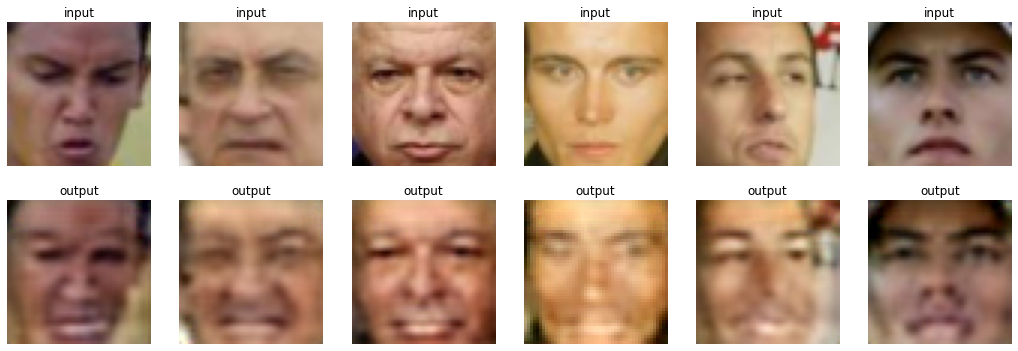

In [31]:
 plt.figure(figsize=(18, 6))
 for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.moveaxis(sad_people.to('cpu').numpy(), 1, 3)[i+1])
    plt.title('input')
    plt.axis('off')
            

    plt.subplot(2, 6, i+7)
    plt.imshow(np.moveaxis(output.detach().to('cpu').numpy(), 1, 3)[i+1])
    plt.title('output')
    plt.axis('off')
    
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в lwf_deepfinetuned.txt =)

# Variational Autoencoder. (3 балла) 

Представляю вам проапгрейдженную версию автоэнкодеров -- вариационные автоэнкодеры.

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [32]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        super().__init__()
        #encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_mu = nn.Linear(7*7*128, latent_dim)
        self.fc_std = nn.Linear(7*7*128, latent_dim)

        #decoder
        self.fc_dec = nn.Linear(latent_dim, 7*7*128)
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2)

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2)

        self.deconv3 = nn.Sequential(
            nn.Conv2d(64, in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )



    def encode(self, x):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.pool1(self.conv1(x))
        #print(x.shape)
        x = self.pool2(self.conv2(x))
        #print(x.shape)
        x = x.view(x.size(0), -1)

        mu = self.fc_mu(x)
        #print(mu.shape)
        logsigma = self.fc_std(x)
        #print(logsigma.shape)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>'''
            std = torch.exp(0.5*logsigma)
            eps = torch.randn_like(std)

            return mu + std*eps
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        '''<реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>'''
        z = self.fc_dec(z)
        z = z.view(z.size(0), 128, 7, 7)
        z = self.upsample1(self.deconv1(z))
        z = self.upsample2(self.deconv2(z))
        reconstruction = self.deconv3(z)
        
        return reconstruction

    def forward(self, x):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        mu, logsigma = self.encode(x)       
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [33]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = torch.mean(-0.5*torch.sum(1 + logsigma - mu**2 - torch.exp(logsigma), dim=1), dim=0)   #<напишите код для KL-дивергенции, пользуясь формулой выше>
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.MSELoss()             #<binary cross-entropy> С бинарной энтропией вылетала cuda постоянно
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + 28*28*log_likelihood(x, reconstruction)

In [34]:
def train_vae(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))[0]

    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
       
        model.train()  # train mode
        for X_batch in data_tr:
            # data to device
            X_batch = X_batch[0].to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            mu, logsigma, X_pred = model(X_batch)
            loss = loss_fn(X_batch, mu, logsigma, X_pred)# forward-pass
            loss.backward()# backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss /len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        _, _, X_hat = model(X_val.to(device)) # detach and put into cpu
       
        val_loss = 0

        for X_batch in data_val:
          # data to device
          X_batch = X_batch[0].to(device)

          with torch.set_grad_enabled(False):
            mu, logsigma, X_pred = model(X_batch)
            loss = loss_fn(X_batch, mu, logsigma, X_pred)

          val_loss += loss  / len(data_val)
        
        history.append((avg_loss, val_loss))

          # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.imshow(X_val.to('cpu').squeeze().numpy()[i])
            plt.title('input')
            plt.axis('off')
            #print(np.moveaxis(X_val.numpy(), 1, 3)[i])
            

            plt.subplot(2, 6, i+7)
            plt.imshow(X_hat.detach().to('cpu').squeeze().numpy()[i])
            plt.title('output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        plot(history)


    return history

И обучим модель:

In [35]:
criterion = loss_vae

vautoencoder = VAE(in_channels=1, latent_dim=20).to(device)

optimizer = optim.AdamW(vautoencoder.parameters(), lr=3e-4)

Загрузим датасет MNIST

In [36]:
data_tr_mnist = DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=128, shuffle=True)

data_val_mnist = DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=128, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw




Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [37]:
from IPython.display import clear_output

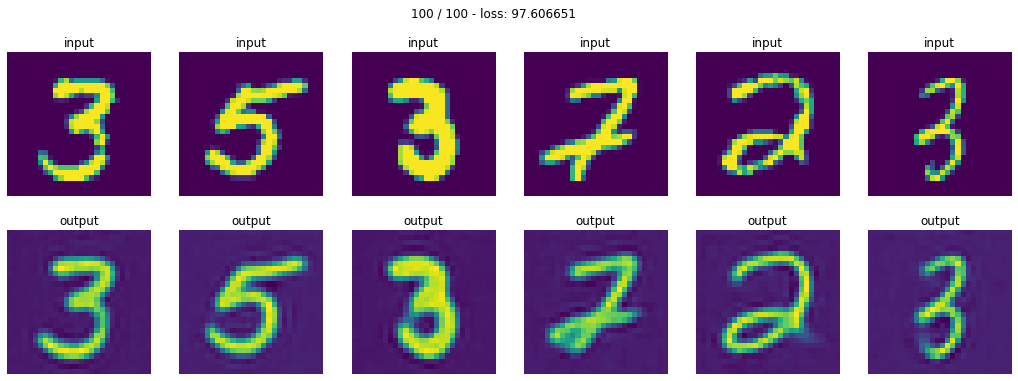

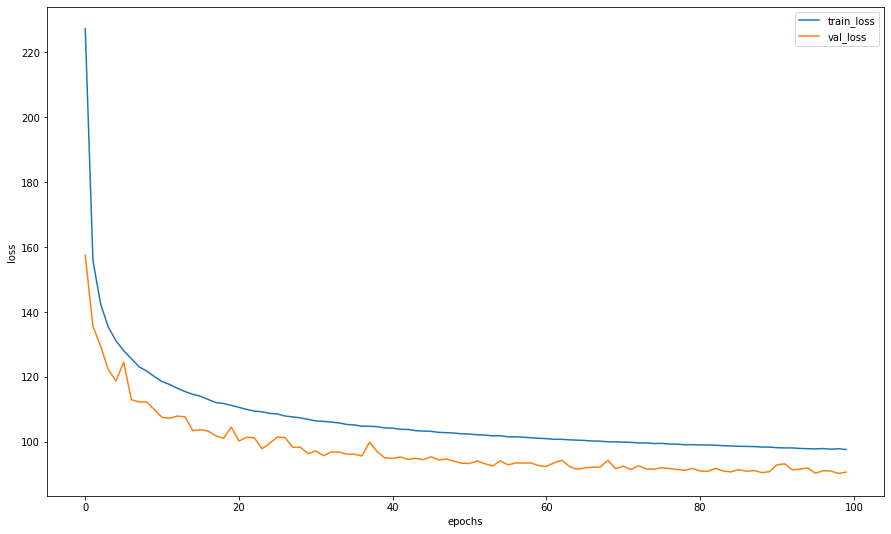

In [ ]:
history = train_vae(vautoencoder, optimizer, criterion, 100, data_tr_mnist, data_val_mnist)

In [ ]:
save_history(history, 'VAE_mnist(100epochs)')

In [ ]:
import copy

model_weights = copy.deepcopy(vautoencoder.state_dict())
torch.save(model_weights, "drive/My Drive/project/VAE_mnist(100epochs).pth")

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
#< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
#при обучении я вывожу реконструкции для валидационной выборки

And finally sample from VAE.

## Sampling

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [40]:
vautoencoder.load_state_dict(torch.load("drive/My Drive/project/VAE_mnist(100epochs).pth"))
vautoencoder.eval()

VAE(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_mu): Linear(in_features=6272, out_features=20, bias=True)
  (fc_std): Linear(in_features=6272, out_features=20, bias=True)
  (fc_dec): Linear(in_features=20, out_features=6272, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()

In [49]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 20) for i in range(10)])
z = torch.FloatTensor(z).to(device)
output = vautoencoder.decode(z)
#<выведите тут полученные картинки>

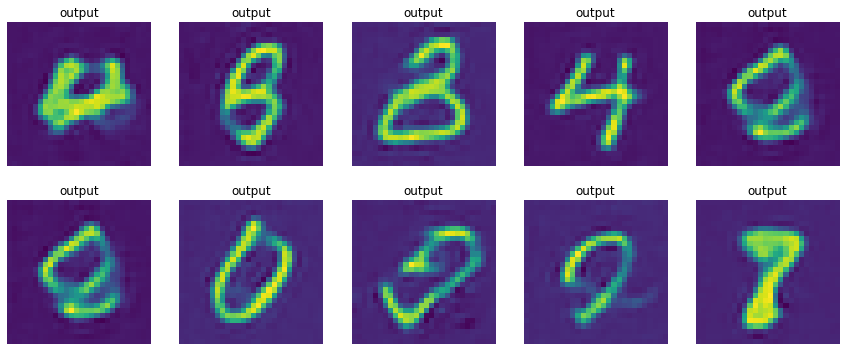

In [50]:
 plt.figure(figsize=(18, 6))
 for i in range(5):
    plt.subplot(2, 6, i+1)
    plt.imshow(output.detach().to('cpu').squeeze().numpy()[i])
    plt.title('output')
    plt.axis('off')
            

    plt.subplot(2, 6, i+7)
    plt.imshow(output.detach().to('cpu').squeeze().numpy()[i+4])
    plt.title('output')
    plt.axis('off')
    
plt.show()

## Latent Representation

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве. 

Это позволит оценить, насколько плотно распределены латентные векторы лиц в пространстве. 

Плюс давайте сделаем такую вещь: у вас есть файл с атрибутами lwf_deepfinetuned.txt, который скачался вместе с базой картинок. Там для каждой картинки описаны атрибуты картинки (имя человека, его пол, цвет кожи и т.п.). Когда будете визуализировать точки латентного пространства на картинке, возьмите какой-нибудь атрибут и покрасьте точки в соответствии со значем атрибута, соответствующего этой точке. 

Например, возьмем атрибут "пол". Давайте покрасим точки, которые соответствуют картинкам женщин, в один цвет, а точки, которые соответствуют картинкам мужчин -- в другой.

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю TSNE (есть в sklearn) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью matplotlib.scatter, покрасить разными цветами точки, соответствующие картинкам с разными атрибутами.

In [57]:
data_test_mnist = DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2000, shuffle=True)

In [58]:
input = next(iter(data_test_mnist))[0].to(device)

In [59]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
mu, logsigma = vautoencoder.encode(input)
latent = vautoencoder.gaussian_sampler(mu, logsigma)
latent = latent.to('cpu').detach().numpy()

In [60]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(latent)

In [61]:
labels = next(iter(data_test_mnist))[1]

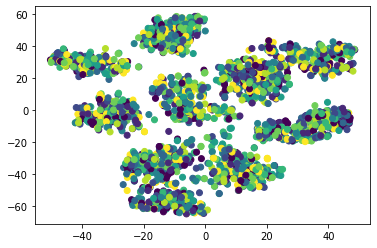

In [62]:
plt.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], c=labels, label=0)
#plt.legend()

Что вы думаете о виде латентного представления?

## Congrats v2.0!

# Conditional VAE (2 балла)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер. 
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица). 
И вот мне понадобилось сгенерировать цифру 8. И я подставляю разные варианты шума, и все никак не генерится восьмерка -- у меня получаются то пятерки, то тройки, то четверки. Гадость(

  Хотелось бы добавить к нашему AE функцию "выдай мне пожалуйста рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).
  Типа я такая говорю "выдай мне случайную восьмерку" и оно генерит случайную восьмерку!

Conditional AE -- так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части проекта мы научимся такие обучать.

## Архитектура

На картинке ниже представлена архитектура простого Conditional AE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки. 

То есть, в первый (входной) слой энкодера есть конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). Первый слой декодера есть конкатенация латентного вектора и информации о классе.


![alt text](https://i.ibb.co/2tsWknB/Screen-Shot-2020-01-15-at-9-02-15-PM.png)



На всякий случай: это VAE, то есть, latent у него состоит из mu и sigma все еще.

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

### P.S.
Можно ередавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

### Датасет
Здесь я предлагаю вам два вариана. Один попроще, другой -- посложнее, но поинтереснее =)

1. Использовать датасет MNIST (http://yann.lecun.com/exdb/mnist/). Обучать conditional VAE на этом датасете, condition -- класс цифры. 

2. Использовать датасет лиц, с которым мы игрались выше. Condition -- пол/раса/улыбки/whatever из lfw_deepfinetuned.txt. 

Почему второй вариант "посложнее" -- потому что я сама еще не знаю, получится ли такой CVAE с лицами или нет =) Вы -- исследователи! (не ну это же проект, так и должно быть)

In [ ]:
#<тут ваш код объявления CVAE, лосса, оптимизатора и тренировки>

Сделал 2 реализации CVAE (линейная и сверточня архитектуры). Лучшие результаты получаются на сверточной архитектуре

In [63]:
class CVAE(nn.Module):
    def __init__(self, latent_dim):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        super().__init__()
        #encoder
        self.enc1 = nn.Sequential(
            nn.Linear(794, 512),
            nn.ReLU()
        )
        
        self.enc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_std = nn.Linear(256, latent_dim)

        #decoder
        self.fc_dec = nn.Linear(latent_dim + 10, 256)
        
        self.dec1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU()
        )

        self.dec2 = nn.Sequential(
            nn.Linear(512, 784)
        )


    def encode(self, x, cond):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = x.view(x.size(0), -1)
        x = torch.cat((x, cond), 1)
        x = self.enc1(x)
        #print(x.shape)
        x = self.enc2(x)
        #print(x.shape)
        

        mu = self.fc_mu(x)
        #print(mu.shape)
        logsigma = self.fc_std(x)
        #print(logsigma.shape)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>'''
            std = torch.exp(0.5*logsigma)
            eps = torch.randn_like(std)

            return mu + std*eps
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, cond):
        '''<реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>'''
        z = torch.cat((z, cond), 1)
        z = self.fc_dec(z)
        z = self.dec1(z)
        z = self.dec2(z)
        z = z.view(z.size(0), 1, 28, 28)
        reconstruction = z
        
        return reconstruction

    def forward(self, x, cond):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        mu, logsigma = self.encode(x, cond)       
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, cond)

        return mu, logsigma, reconstruction

In [64]:
class CVAE2(nn.Module):
    def __init__(self, in_channels, latent_dim):
        '''<определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста", 
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>'''
        super().__init__()
        #encoder
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = nn.Sequential(
            nn.Linear(7*7*128+10, 400),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_std = nn.Linear(400, latent_dim)

        #decoder
        self.fc_dec = nn.Linear(latent_dim +10, 400)
        
        self.dec1 = nn.Sequential(
            nn.Linear(400, 7*7*128),
            nn.ReLU()
        )
        
        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2)

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample2 = nn.Upsample(scale_factor=2)

        self.deconv3 = nn.Sequential(
            nn.Conv2d(64, in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
        )



    def encode(self, x, cond):
        #<реализуйте forward проход энкодера
        #в качестве ваозвращаемых переменных -- mu и logsigma>
        x = self.pool1(self.conv1(x))
        #print(x.shape)
        x = self.pool2(self.conv2(x))
        #print(x.shape)
        x = x.view(x.size(0), -1)
        x = torch.cat((x, cond), 1)
        x = self.enc3(x)

        mu = self.fc_mu(x)
        #print(mu.shape)
        logsigma = self.fc_std(x)
        #print(logsigma.shape)
        
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            '''<засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>'''
            std = torch.exp(0.5*logsigma)
            eps = torch.randn_like(std)

            return mu + std*eps
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z, cond):
        '''<реализуйте forward проход декодера
        в качестве ваозвращаемой переменной -- reconstruction>'''
        z = torch.cat((z, cond), 1)
        z = self.fc_dec(z)
        z = self.dec1(z)
        z = z.view(z.size(0), 128, 7, 7)
        z = self.upsample1(self.deconv1(z))
        z = self.upsample2(self.deconv2(z))
        reconstruction = self.deconv3(z)
        
        return reconstruction

    def forward(self, x, cond):
        '''<используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>'''
        mu, logsigma = self.encode(x, cond)       
        z = self.gaussian_sampler(mu, logsigma)
        reconstruction = self.decode(z, cond)

        return mu, logsigma, reconstruction

In [65]:
X_val = next(iter(data_val_mnist))[0]
cond =  next(iter(data_val_mnist))[1].unsqueeze(1).numpy()

In [66]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
ohe = enc.fit_transform(cond).toarray()

In [67]:
ohe = torch.FloatTensor(ohe)

In [68]:
torch.cat((X_val.view(X_val.size(0),-1), ohe), 1).shape

torch.Size([128, 794])

In [69]:
def train_cvae(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))[0]
    cond_val = next(iter(data_val))[1].unsqueeze(1).numpy()

    cond_val = enc.transform(cond_val).toarray()
    cond_val = torch.FloatTensor(cond_val)

    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
       
        model.train()  # train mode
        for X_batch in data_tr:
            # data to device
            cond = X_batch[1].unsqueeze(1).numpy()
            X_batch = X_batch[0].to(device)

            cond = enc.transform(cond).toarray()
            cond = torch.FloatTensor(cond).to(device)


            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            mu, logsigma, X_pred = model(X_batch, cond)
            loss = loss_fn(X_batch, mu, logsigma, X_pred)# forward-pass
            loss.backward()# backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss /len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        _, _, X_hat = model(X_val.to(device), cond_val.to(device)) # detach and put into cpu
       
        val_loss = 0

        for X_batch in data_val:
          # data to device
          cond = X_batch[1].unsqueeze(1).numpy()
          X_batch = X_batch[0].to(device)

          cond = enc.transform(cond).toarray()
          cond = torch.FloatTensor(cond).to(device)

          with torch.set_grad_enabled(False):
            mu, logsigma, X_pred = model(X_batch, cond)
            loss = loss_fn(X_batch, mu, logsigma, X_pred)

          val_loss += loss  / len(data_val)
        
        history.append((avg_loss, val_loss))

          # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 6))
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.imshow(X_val.to('cpu').squeeze().numpy()[i])
            plt.title('input')
            plt.axis('off')
            #print(np.moveaxis(X_val.numpy(), 1, 3)[i])
            

            plt.subplot(2, 6, i+7)
            plt.imshow(X_hat.detach().to('cpu').squeeze().numpy()[i])
            plt.title('output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        plot(history)


    return history

In [70]:
criterion = loss_vae

cvautoencoder = CVAE2(1, 20).to(device)

optimizer = optim.AdamW(cvautoencoder.parameters(), lr=1e-3)

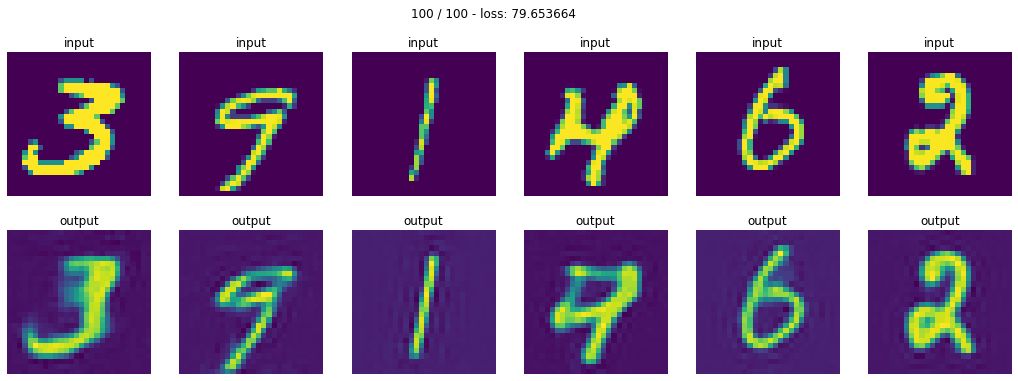

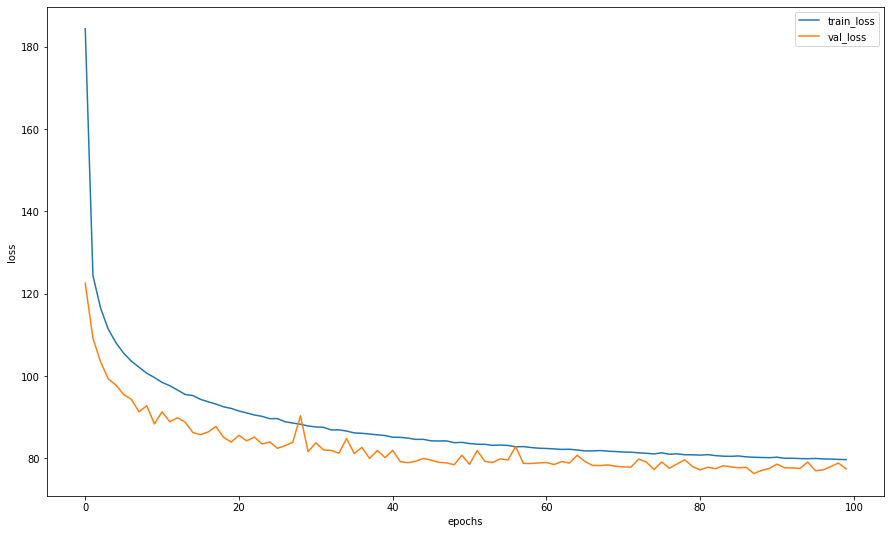

In [ ]:
history = train_cvae(cvautoencoder, optimizer, criterion, 100, data_tr_mnist, data_val_mnist)

In [ ]:
save_history(history, 'CVAE(100epochs)')

In [ ]:
import copy

model_weights = copy.deepcopy(cvautoencoder.state_dict())
torch.save(model_weights, "drive/My Drive/project/CVAE(100epochs).pth")

## Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора картинки цифры 5 и 7, а для лиц людей -- восстановить лицо улыбающегося и хмурого человека или лица людей разного пола (смотря на чем был ваш кондишен)

In [ ]:
#<тут нужно научиться сэмплировать из декодера цифры определенного класса>

In [72]:

cvautoencoder.load_state_dict(torch.load("drive/My Drive/project/CVAE(100epochs).pth"))
cvautoencoder.eval()

CVAE2(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc3): Sequential(
    (0): Linear(in_features=6282, out_features=400, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=400, out_features=20, bias=True)
  (fc_std): Linear(in_features=400, out_features=20, bias=True)
  (fc_dec): Linear(in_features=30, out_features=400, bias=True)
  (dec1): Sequential(
    (0): Linear(in_features=400, out_features=6272, bias=True)
    (1): ReLU()
  )
  (de

Визуализируем пятерки

In [73]:
z5 = np.array([np.random.normal(0, 1, 20) for i in range(10)])
z5 = torch.FloatTensor(z5).to(device)

In [74]:
cond5 = np.array((10*[5])).reshape((10,1))
cond5 = enc.transform(cond5).toarray()

In [75]:
cond5 = torch.FloatTensor(cond5).to(device)

In [76]:
output = cvautoencoder.decode(z5, cond5)

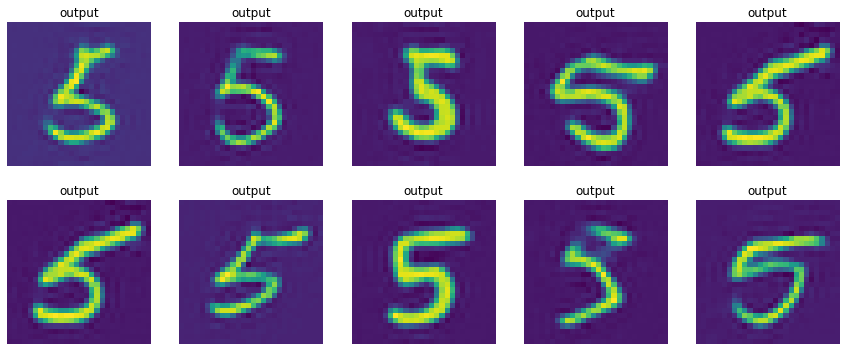

In [77]:
 plt.figure(figsize=(18, 6))
 for i in range(5):
    plt.subplot(2, 6, i+1)
    plt.imshow(output.detach().to('cpu').squeeze().numpy()[i])
    plt.title('output')
    plt.axis('off')
            

    plt.subplot(2, 6, i+7)
    plt.imshow(output.detach().to('cpu').squeeze().numpy()[i+4])
    plt.title('output')
    plt.axis('off')
    
plt.show()

А теперь посмотрим на семерки

In [78]:
z7 = np.array([np.random.normal(0, 1, 20) for i in range(10)])
z7 = torch.FloatTensor(z7).to(device)

In [79]:
cond7 = np.array((10*[7])).reshape((10,1))
cond7 = enc.transform(cond7).toarray()

In [80]:
cond7 = torch.FloatTensor(cond7).to(device)

In [81]:
output = cvautoencoder.decode(z7, cond7)

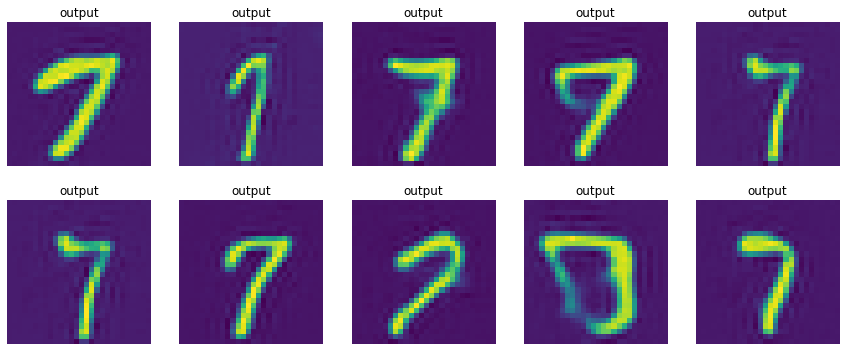

In [85]:
 plt.figure(figsize=(18, 6))
 for i in range(5):
    plt.subplot(2, 6, i+1)
    plt.imshow(output.detach().to('cpu').squeeze().numpy()[i])
    plt.title('output')
    plt.axis('off')
            

    plt.subplot(2, 6, i+7)
    plt.imshow(output.detach().to('cpu').squeeze().numpy()[i+4])
    plt.title('output')
    plt.axis('off')
    
plt.show()

Splendid! Вы великолепны!

Ну круто же, ну?

## Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>

In [86]:
data_test_mnist = DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=2000, shuffle=True)

In [87]:
input = next(iter(data_test_mnist))[0].to(device)

In [88]:
labels = next(iter(data_test_mnist))[1].unsqueeze(1).numpy()
cond = enc.transform(labels).toarray()
cond = torch.FloatTensor(cond).to(device)

In [89]:
#<ваш код получения латентных представлений, применения TSNE и визуализации>
mu, logsigma = cvautoencoder.encode(input, cond)
latent = cvautoencoder.gaussian_sampler(mu, logsigma)
latent = latent.to('cpu').detach().numpy()

In [90]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(latent)

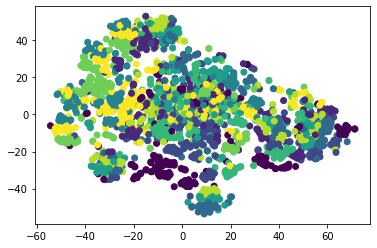

In [91]:
plt.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], c=labels)
#plt.legend()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Image Morphing (1 балл) 

<a href="https://ibb.co/rxr9YgL"><img src="https://i.ibb.co/D92dhN6/1-6y-Okto2-BUp-ONJpk5x-LRMtw.png" alt="1-6y-Okto2-BUp-ONJpk5x-LRMtw" border="0"></a>

Предлагаю вам поиграться не только с улыбками, но и с получением из одного человека другого!

План:
1. Берем две картинки разных людей из датасета
2. Получаем их латентные представления X и Y
3. Складываем латентные представления с коэффициентом $\alpha$:
  $$\alpha X + (1-\alpha) Y$$
  где $\alpha$ принимает несколько значений от 0 до 1 
4. Визуализируем, как один человек превращается в другого!

Используем обученный в первом задании автоэнкодер

In [92]:
autoencoder.load_state_dict(torch.load("drive/My Drive/project/AE(100epochs).pth"))
autoencoder.eval()

Autoencoder(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (deconv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (upsample1): Upsample(scale_factor=2.0, mode=nearest)
  (deconv2): Sequential(
    (0): Con

In [93]:
np.rollaxis(val.numpy(), 2, 1).shape

(3286, 48, 3, 48)

Выберем 2 изображения лиц

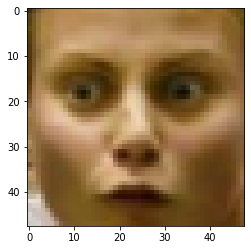

In [94]:
plt.imshow(np.moveaxis(val.numpy(), 1, 3)[125])

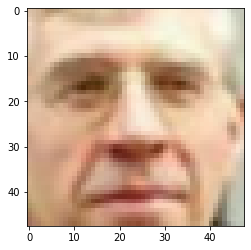

In [100]:
plt.imshow(np.moveaxis(val.numpy(), 1, 3)[87])

In [101]:
person1 = val[125].unsqueeze(0).to(device)
person2 = val[87].unsqueeze(0).to(device)
alphas = np.arange(0, 1.1, 0.1)

In [102]:
_, latent_person1 = autoencoder(person1)
_, latent_person2 = autoencoder(person2)

In [103]:
latents = []
for alpha in alphas:
  latent = alpha*latent_person2 + (1-alpha)*latent_person1
  latents.append(latent)

In [104]:
faces = []
for latent in latents:
  latent = latent.to(device)
  face = autoencoder.recovery(latent).to('cpu')
  faces.append(face)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


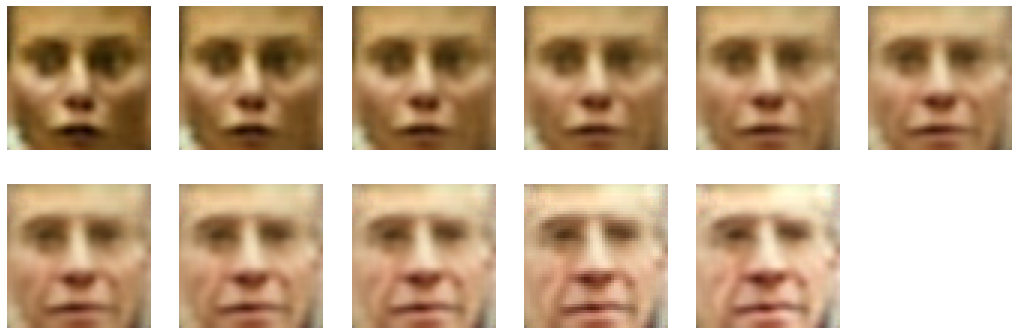

In [105]:
 plt.figure(figsize=(18, 6))
 for i in range(11):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.moveaxis( faces[i].detach().numpy(), 1, 3).squeeze())
    plt.axis('off')

# BONUS 2: Denoising (2 балла) 

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них это бонусное задание.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума. 
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для того, чтобы поставить эксперимент, нужно взять ваш любимый датасет (датасет лиц или MSE с прошлых заданий или любой другой) и сделать копию этого датасета с шумом. 

В питоне шум можно добавить так:

In [ ]:
#noise_factor = 0.5
#X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

In [106]:
noise_factor = 0.8

In [107]:
def train_noise(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val = next(iter(data_val))[0]
    X_val_noise = torch.FloatTensor(X_val.numpy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_val.numpy().shape) )
    
    history = []

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
       
        model.train()  # train mode
        for X_batch in data_tr:
            # data to device
            X_batch = X_batch[0].to(device)
            X_batch_noise = torch.FloatTensor(X_batch.to('cpu').numpy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_batch.to('cpu').numpy().shape) ).to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            mu, logsigma, X_pred = model(X_batch_noise)
            #print(X_pred.shape)
            loss = loss_fn(X_batch, mu, logsigma, X_pred)# forward-pass
            loss.backward()# backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss /len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        _, _, X_hat = model(X_val_noise.to(device)) # detach and put into cpu
       
        val_loss = 0

        for X_batch in data_val:
          # data to device
          X_batch = X_batch[0].to(device)
          X_batch_noise = torch.FloatTensor(X_batch.to('cpu').numpy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_batch.to('cpu').numpy().shape) ).to(device)

          with torch.set_grad_enabled(False):
            mu, logsigma, X_pred = model(X_batch_noise)
            loss = loss_fn(X_batch, mu, logsigma, X_pred)

          val_loss += loss  / len(data_val)
        
        history.append((avg_loss, val_loss))

          # Visualize tools
        clear_output(wait=True)
        plt.figure(figsize=(18, 12))
        for i in range(6):
            plt.subplot(3, 6, i+1)
            plt.imshow(X_val.to('cpu').squeeze().numpy()[i])
            plt.title('real')
            plt.axis('off')

            plt.subplot(3, 6, i+7)
            plt.imshow(X_val_noise.to('cpu').squeeze().numpy()[i])
            plt.title('input')
            plt.axis('off')
            #print(np.moveaxis(X_val.numpy(), 1, 3)[i])
            

            plt.subplot(3, 6, i+13)
            plt.imshow(X_hat.detach().to('cpu').squeeze().numpy()[i])
            plt.title('output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        plot(history)


    return history

In [108]:
#<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>
criterion = loss_vae

noise_vautoencoder = VAE(in_channels=1, latent_dim=20).to(device)

optimizer = optim.AdamW(noise_vautoencoder.parameters(), lr=1e-3)

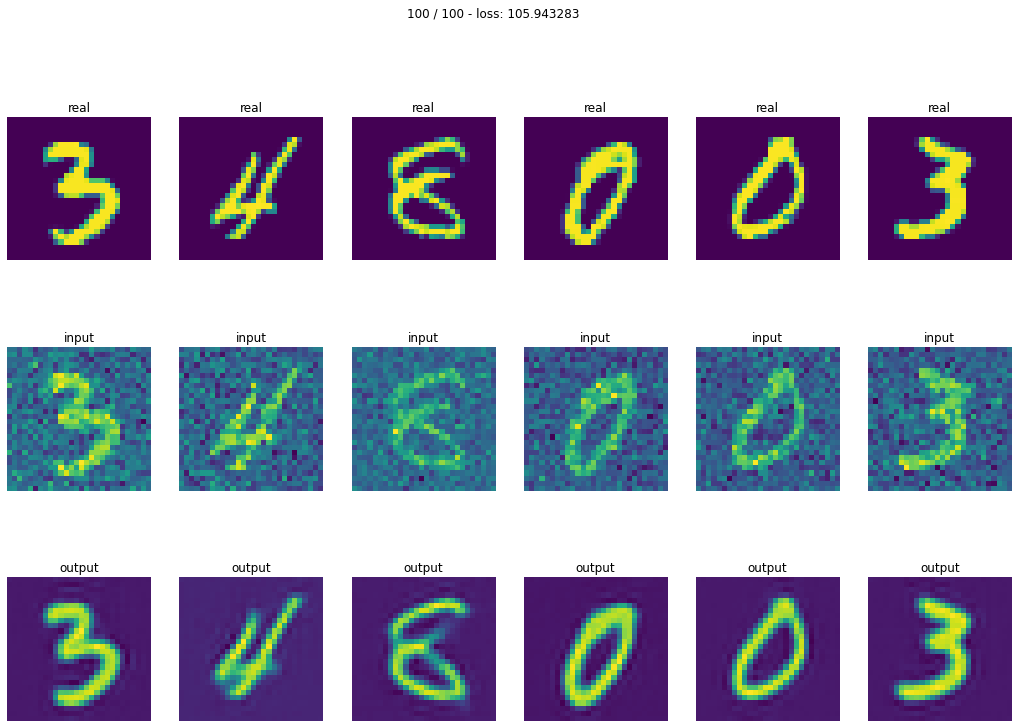

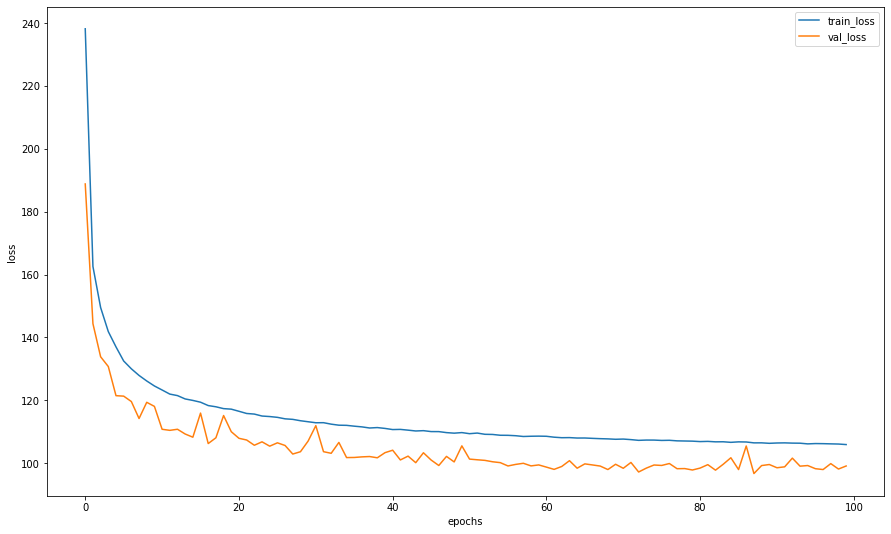

In [ ]:
#<тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>
history = train_noise(noise_vautoencoder, optimizer, criterion, 100, data_tr_mnist, data_val_mnist)

In [110]:
noise_vautoencoder.load_state_dict(torch.load("drive/My Drive/project/VAE_noise(100epochs).pth"))
noise_vautoencoder.eval()

VAE(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_mu): Linear(in_features=6272, out_features=20, bias=True)
  (fc_std): Linear(in_features=6272, out_features=20, bias=True)
  (fc_dec): Linear(in_features=20, out_features=6272, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()

In [111]:
x_val = next(iter(data_tr_mnist))[0]
x_val_noise = torch.FloatTensor(x_val.numpy() + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val.numpy().shape)).to(device)

In [112]:
_, _, output = noise_vautoencoder(x_val_noise)

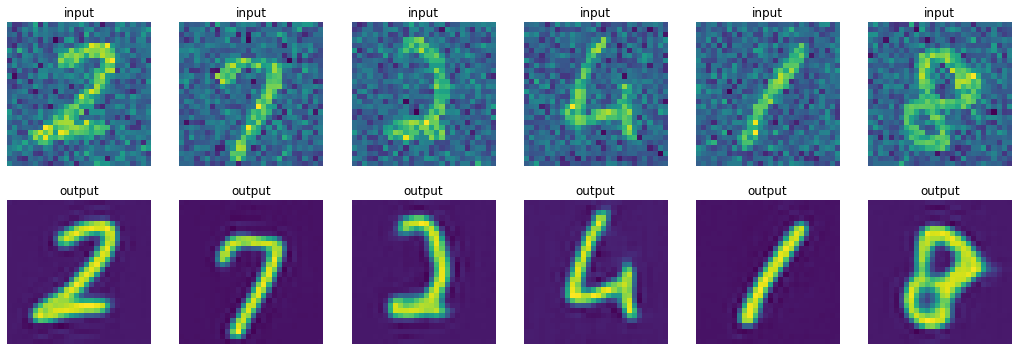

In [113]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(x_val_noise.to('cpu').squeeze().numpy()[i])
    plt.title('input')
    plt.axis('off')
    #print(np.moveaxis(X_val.numpy(), 1, 3)[i])

    plt.subplot(2, 6, i+7)
    plt.imshow(output.detach().to('cpu').squeeze().numpy()[i])
    plt.title('output')
    plt.axis('off')
plt.show()

In [ ]:
save_history(history, 'VAE_niise(100epochs)')

In [ ]:
import copy

model_weights = copy.deepcopy(noise_vautoencoder.state_dict())
torch.save(model_weights, "drive/My Drive/project/VAE_noise(100epochs).pth")

## Бонус 2.1: Occlusion (+еще 1 балл)

<a href="https://imgbb.com/"><img src="https://i.ibb.co/wYrKtQY/Screen-Shot-2020-06-04-at-5-06-35-PM.png" alt="Screen-Shot-2020-06-04-at-5-06-35-PM" border="0" width="300" height="300"></a>

Автоэнкодерами можно не только убирать шум, но и восстанавливать части картинки, которые чем-то закрыты! 

Эксперимент здесь такой: вместо наложения шума на картинку, "закрываем" часть картинки заплаткой и тренируем AE/VAE восстанавливать закрытую часть картинки.

Важно, чтобы заплатка была не очень большая. 

In [ ]:
<тут ваш код обучения автоэнкодера на occluded (простите, не знаю, как это сказать по-русски) картинках. Не забудтье разбить на train/test!>

# Bonus 3: Image Retrieval (1 балл)

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest (sklearn.neighbors.LSHForest), например, с n_estimators=50
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>
    
  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

# Bonus 4: Телеграм-бот (3 балла)

Вы можете написать телеграм-бота с функционалом AE. Например, он может добавлять к вашей фотографии улыбку или искать похожие на ваше лицо лица среди лиц датасета. 

Код бота должно быть можно проверить!

# Эпилог

здесь мы рассмотрели не все применения автоэнкодеров. Еще есть, например:

-- поиск аномалий
-- дополнение отсутствующих частей картины
-- работа с sequential данными (например, временными рядами)
-- гибриды ГАН+АЕ, которые активно изучаются в последнее время
-- использование латентных переменных АЕ в качестве фичей
...

Они не были частью этого проекта, потому что для их реализации пришлось бы больше возиться с датасетами. 

Но! Если вы хотите, вы, конечно, всегда можете реализовать еще что-то и получить за это еще допбаллы.

Надеюсь, вам понравилось!